## Basics

In [1]:
from primitives import Parameters
p = Parameters()
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(0)

(100,)


In [3]:
#%%timeit
from Multiworker_Contract import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1)=mwc.J()
#(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1)=mwc.J(0,mwc_J,mwc_W)

Ji shape (1, 3, 3, 100)
W1i shape (1, 3, 3, 100, 2)
Errors: nan 0.05092020001051513 nan 5.530688589348877 1
Errors: nan 0.05092020001051513 nan 5.530688589348877 1


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:173: RuntimeWarning: invalid value encountered in scalar divide
  self.gamma_all[iz, in0, in1, 1] = ( (Xi-xbar) * (Yi-ybar) * W ).sum() / (  (Xi-xbar) * (Xi-ybar) * W ).sum()


EJinv 160.8783028034278
EJ_star direct deriv 145.70923967426097
EJstar adjusted deriv 145.70923967424676
EJinv diff: 0.27356733864386235
EJinv diff 1 sen: nan
EJinv 157.82010961966253
EJ_star direct deriv 142.996483613814
EJstar adjusted deriv 142.9964836137998
EJinv diff: 0.3668905477723284
EJinv diff 1 sen: nan


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract.py:290: RuntimeWarning: invalid value encountered in divide
  print("EJinv diff 1 sen:", np.mean(np.power((EJinv[:,0,1,:]/pc_star[:,0,1,:] - EJstardiff[:,0,1,:]) / EJstardiff[:,0,1,:],2)))


EJinv 154.8314996357322
EJ_star direct deriv 140.34509419325047
EJstar adjusted deriv 140.34509419325047
EJinv diff: 0.45101331712641624
EJinv diff 1 sen: nan
EJinv 151.9108237175218
EJ_star direct deriv 137.75362114725453
EJstar adjusted deriv 137.75362114725453
EJinv diff: 0.5238841181510231
EJinv diff 1 sen: nan
EJinv 149.05647258071843
EJ_star direct deriv 135.22064917553678
EJstar adjusted deriv 135.22064917555699
EJinv diff: 0.5852075816800073
EJinv diff 1 sen: nan
EJinv 146.2666325470395
EJ_star direct deriv 132.57746107710489
EJstar adjusted deriv 132.57746107708462
EJinv diff: 0.6353992014883105
EJinv diff 1 sen: nan
EJinv 143.53141235858192
EJ_star direct deriv 130.14901659563805
EJstar adjusted deriv 130.14901659563805
EJinv diff: 0.6760746525321123
EJinv diff 1 sen: nan
EJinv 140.85763946036593
EJ_star direct deriv 127.77480590217749
EJstar adjusted deriv 127.77480590217144
EJinv diff: 0.7084829932611764
EJinv diff 1 sen: nan
EJinv 138.2438719936616
EJ_star direct deriv 125

In [7]:
cc_J[0,0]

37.107340956356786

In [9]:
cc_W[0,0]

159.93515830832132

In [6]:
mwc_J[0,0,1,0]

38.289633140525495

In [9]:
mwc_W[0,0,2,0,1]

160.52770367285694

In [6]:
mwc_W[0,0,1,0,1]

160.52770367260746

In [7]:
mwc_W[0,0,0,:,1]-mwc_W[0,0,1,:,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
#%%timeit
from Multiworker_Contract_copy import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
#(mwc_J,mwc_W,mwc_Wstar,mwc_pc)=mwc.J()
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1)=mwc.J()

In [ ]:
#%%timeit
from Multiworker_Contract_diff_inter import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
#(mwc_J,mwc_W,mwc_Wstar,mwc_pc)=mwc.J()
(mwc_inter_J,mwc_inter_W,mwc_inter_Wstar,mwc_inter_pc)=mwc.J()

In [ ]:
#%%timeit
from Multiworker_Contract_sep import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_s_pc)=mwc.J()

In [ ]:
#%%timeit
from Multiworker_Contract_sep_direct import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_s_pc)=mwc.J()

# Plots

In [4]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

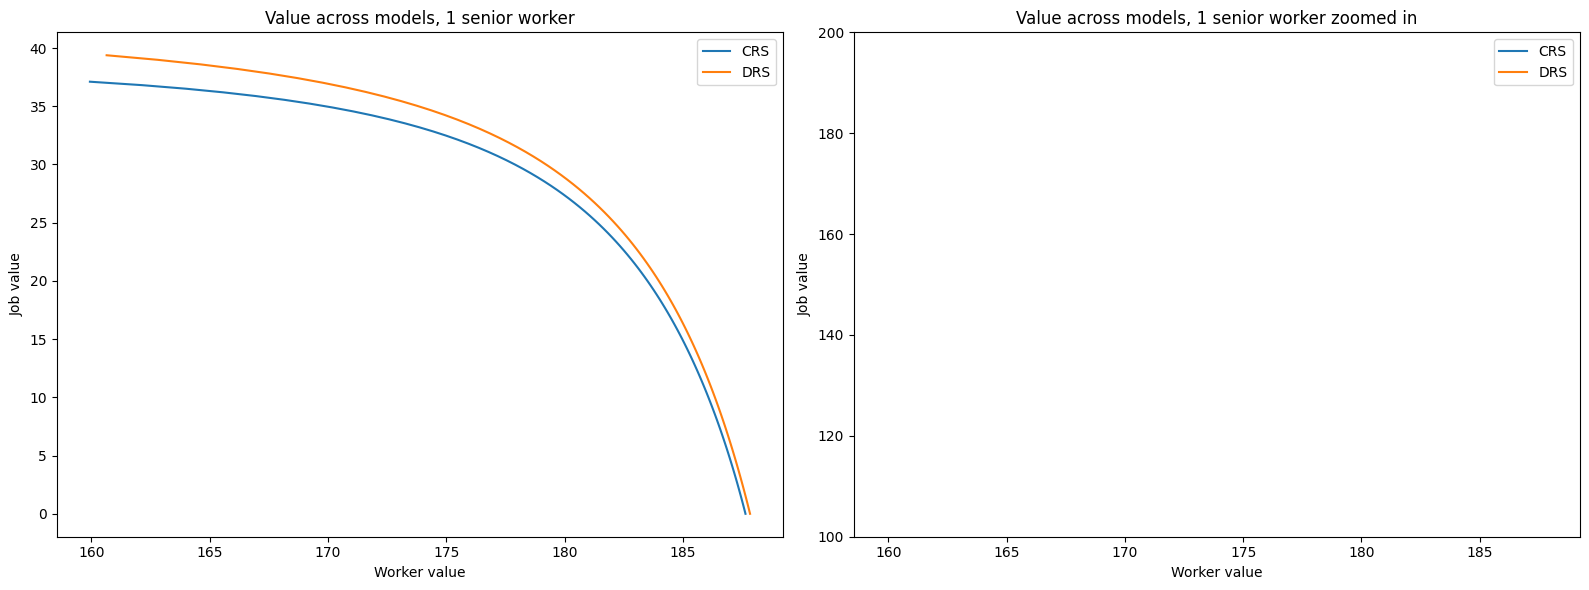

In [5]:
# Create a figure with a specific size
plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
# Plot the data
plt.plot(cc_W[p.z_0-1, :], cc_J[p.z_0-1, :], label='CRS')
plt.plot(mwc_W[p.z_0-1, 0, 1, :, 1], mwc_J[p.z_0-1, 0, 1, :], label='DRS')
#plt.plot(mwc_inter_W[p.z_0-1, 0, 1, :, 1], mwc_inter_J[p.z_0-1, 0, 1, :], label='DRS with extrapolation')
#plt.plot(mwc_s_W[p.z_0-1, 0, 1, :, 1], mwc_s_J[p.z_0-1, 0, 1, :], label='DRS with separations')
# Add titles and labels
plt.title('Value across models, 1 senior worker')
plt.xlabel('Worker value')
plt.ylabel('Job value')

plt.legend()

#plt.ylim([0, 200])

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(cc_W[p.z_0-1, :], cc_J[p.z_0-1, :], label='CRS')
plt.plot(mwc_W[p.z_0-1, 0, 1, :, 1], mwc_J[p.z_0-1, 0, 1, :], label='DRS')
#plt.plot(mwc_inter_W[p.z_0-1, 0, 1, :, 1], mwc_inter_J[p.z_0-1, 0, 1, :], label='DRS with extrapolation')
#plt.plot(mwc_s_W[p.z_0-1, 0, 1, :, 1], mwc_s_J[p.z_0-1, 0, 1, :], label='DRS with separations')

# Add titles and labels
plt.title('Value across models, 1 senior worker zoomed in')
plt.xlabel('Worker value')
plt.ylabel('Job value')

plt.ylim([100, 200])

plt.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Add legend
plt.legend()

# Save the plot to a file in the specified directory
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS.png'), bbox_inches='tight')  # Save as PNG


# Optionally set x and y limits
#plt.xlim([-10, 40])
#plt.ylim([0, 200])
# Save the plot to a file
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS zoom.png'), bbox_inches='tight')  # Save as PNG

# Show the plot (optional)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import os

# Create a figure with a specific size
plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(mwc_W[p.z_0-1, 0, 3, :, 1], mwc_J[p.z_0-1, 0, 3, :], label='DRS')
plt.plot(mwc_inter_W[p.z_0-1, 0, 3, :, 1], mwc_inter_J[p.z_0-1, 0, 3, :], label='DRS with extrapolator')
plt.title('Value across models, 1 junior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

#plt.ylim([0, 200])

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(mwc_W[p.z_0-1, 2, 2, :, 1], mwc_J[p.z_0-1, 2, 2, :], label='DRS')
plt.plot(mwc_inter_W[p.z_0-1, 1, 2, :, 1], mwc_inter_J[p.z_0-1, 1, 2, :], label='DRS with extrapolator')
plt.title('Value across models, 1 junior and 1 senior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

#plt.xlim([-10, 10])
#plt.ylim([220, 240])

# Save the plot to a file in the specified directory
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS.png'), bbox_inches='tight')  # Save as PNG

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import os

# Create a figure with a specific size
plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(mwc_W[p.z_0-1, 1, 0, :, 1], mwc_J[p.z_0-1, 1, 0, :], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, 1, 0, :, 1], mwc_s_J[p.z_0-1, 1, 0, :], label='DRS with sep')
plt.title('Value across models, 1 junior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

#plt.ylim([0, 200])

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(mwc_W[p.z_0-1, 0, 3, :, 1], mwc_J[p.z_0-1, 0, 3, :], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, 0, 3, :, 1], mwc_s_J[p.z_0-1, 0, 3, :], label='DRS with sep')
plt.title('Value across models, 1 junior and 1 senior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

#plt.xlim([-10, 10])
#plt.ylim([220, 240])

# Save the plot to a file in the specified directory
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS.png'), bbox_inches='tight')  # Save as PNG

# Show the plot
plt.show()

In [ ]:
mwc_s_sep[0,0,1,:]

In [ ]:
import matplotlib.pyplot as plt
import os

# Create a figure with a specific size
plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(mwc_W[p.z_0-1, 1, 0, :, 1], mwc_J[p.z_0-1, 1, 0, :], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, 1, 0, :, 1], mwc_s_J[p.z_0-1, 1, 0, :], label='DRS with sep')
plt.title('Value across models, 1 junior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

#plt.ylim([0, 200])

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(mwc_W[p.z_0-1, 1, 1, :, 1], mwc_J[p.z_0-1, 1, 1, :], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, 1, 1, :, 1], mwc_s_J[p.z_0-1, 1, 1, :], label='DRS with sep')
plt.title('Value across models, 1 junior and 1 senior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

#plt.xlim([-10, 10])
#plt.ylim([220, 240])

# Save the plot to a file in the specified directory
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS.png'), bbox_inches='tight')  # Save as PNG

# Show the plot
plt.show()


In [ ]:
mwc_s_sep[0,1,1,:] #if the two value functions intersect, then how come the separation rate is 1?
#also thats way too many separations

In [ ]:
plt.figure(figsize=(8, 6))  # Width=16 inches, Height=12 inches

# Plot the data
plt.plot(cc_J[p.z_0-1, :], mwc_J[p.z_0-1, 0, 1, :], label='CRS vs DRS')

In [ ]:
plt.figure(figsize=(8, 6))  # Width=16 inches, Height=12 inches

# Plot the data
plt.plot(cc_W[p.z_0-1, :], cc_Wstar[p.z_0-1, :]-cc_W[p.z_0-1, :], label='CRS')
plt.plot(mwc_W[p.z_0-1, 0, 1,:, 1], mwc_Wstar[p.z_0-1, 0, 1, :]-mwc_W[p.z_0-1, 0, 1,:, 1], label='DRS')
plt.legend()
# Add titles and labels
plt.title('Future value across types')
plt.xlabel('Worker value')
plt.ylabel('Value change over time')

In [ ]:
mwc.sum_size[0,1,0,0]

In [ ]:
mwc.w_grid[10]*mwc.sum_size[0,2,1,10]
mwc.sum_wage[0,0,2,10]

In [ ]:
np.log(mwc.w_grid[99])/(1-p.beta)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))#This creates a figure and a set of subplots with a specific size. The size is specified in inches (width, height).

# Plot the original data
ax.plot(cc_W[p.z_0-1,:]+cc_J[p.z_0-1,:], mwc_W[p.z_0-1, 0, 1,:,1]+J_deriv[p.z_0-1, 0, 1, :], label='Total surplus')

# Calculate the range for the 45-degree line
x_vals = cc_W[p.z_0-1,:] + cc_J[p.z_0-1,:]
y_vals = mwc_W[p.z_0-1, 0, 1,:,1] + J_deriv[p.z_0-1, 0, 1, :]
min_val = min(min(x_vals), min(y_vals))
max_val = max(max(x_vals), max(y_vals))

# Add the 45-degree line
ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='45-degree line')

# Add titles and labels
ax.set_title('Comparing total surplus across methods')
ax.set_xlabel('Total surplus (CRS)')
ax.set_ylabel('Total surplus (DRS)')
ax.legend()

# Save the plot to a file
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Total surplus comparison.png'), bbox_inches='tight')  # Save as PNG
#    plt.savefig(os.path.join(output_dir,'Total surplus comparison.pdf'), bbox_inches='tight')  # Save as PDF

# Show the plot
plt.show()